In [17]:


import kaggle
import os

from glob import glob

from PIL import Image,ImageStat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


## Intel Image Dataset
[dataset link](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data)

The Intel image dataset features photographs of natural landscapes from across the globe. It comprises roughly 25k images, each measuring 150x150 pixels, categorized into six groups. The dataset is divided into about 14k images for training, 3k for testing, and 7k for prediction (kaggle only).


In [4]:
# Loads a dataset from a subdirectory.
def load_dataset(datapath):
    df = pd.DataFrame( )
    
    for folder in os.listdir(datapath):
        files = glob(pathname= str(datapath + folder + '/*.jpg'))
        df = pd.concat( [ df, pd.DataFrame( { 'filename': files , 
                                              'category': folder } ) ] )
    
    df = df.sort_values(by="category", ignore_index=True)    
       
    return df

# Get a whole bunch of stats from an image
# Note we do a HSV and L convert in this function.
# Would be better to break that out such that subsequent steps
# could use those images.
def load_image(row):
    row['image'] = Image.open(row['filename'])
    row['resolution'] = row['image'].size

    row['hsv_image'] = row['image'].convert('HSV')
    row['gray_image'] = row['image'].convert('L')
    
    return row

def get_hsv_stats(row):

    hsv_stats = ImageStat.Stat(row['hsv_image'])

    row['extrema_h'] = hsv_stats.extrema[0]
    row['extrema_s'] = hsv_stats.extrema[1]
    row['extrema_v'] = hsv_stats.extrema[2]
    row['stddev_h'] = hsv_stats.stddev[0]
    
    return row
    

def get_gray_stats(row):
    gray_stats = ImageStat.Stat(row['gray_image'])
    row['extrema_l'] = gray_stats.extrema[0]
    row['mean_l'] = gray_stats.mean[0]
    row['stddev_l'] = gray_stats.stddev[0]

    return row




In [28]:

if not os.path.isdir('dataset'):
  kaggle.api.authenticate()
  kaggle.api.dataset_download_files('puneet6060/intel-image-classification', path='dataset', unzip=True)
  

train_path = 'dataset/seg_train/seg_train/'
test_path = 'dataset/seg_test/seg_test/'

training_set = load_dataset(train_path)
testing_set = load_dataset(test_path)

training_set = training_set.apply(load_image, axis = 1)
training_set = training_set.apply(get_hsv_stats, axis = 1)
training_set = training_set.apply(get_gray_stats, axis = 1)

#training_set.drop(training_set[training_set.resolution != "150x150"].index, inplace=True)


In [33]:
# Drop low res images
training_set.drop(training_set[training_set.resolution != (150,150)].index, inplace=True)

In [65]:
def create_half_size(img):
    reduced_img = img.reduce(2)
    if reduced_img.size[0] == 1:
        return np.array(reduced_img)

    return np.append( reduced_img, create_half_size(reduced_img) )


def extract_hue_feature_vector(row):
    row['hue_vector'] = create_half_size(row['hsv_image'].getchannel('H'))[0:1000]
    return row

training_set = training_set.apply(extract_hue_feature_vector, axis = 1)

# Example
plt.plot(training_set.iloc[0]['hue_vector'])
plt.title("Example Hue Feature Vector")
plt.show()


In [58]:
v = np.stack(training_set['hue_vector'].to_numpy())


5 0.7973876153720006
10 0.8322880032712183
15 0.8503361172452175
20 0.862816726086665
25 0.8723205517145205
30 0.8799807895157471
35 0.8864832418229945
40 0.892135686631622
45 0.8971424554374721
50 0.9013789319255933
55 0.905482444186836
60 0.909428749065502
65 0.9129228967117926
70 0.9162344674300478
75 0.9192747438672133
80 0.9223599748917214
85 0.9251098011931023
90 0.9275794983012627
95 0.9301276446612725
100 0.9324600541571104
105 0.9347046850375886
110 0.936821734088153
115 0.9388909320139129
120 0.9408895727926639
125 0.9428266120867482
130 0.9445984983221397
135 0.9463930964792856
140 0.9480420483264254
145 0.9497907708317259
150 0.9513130277460032
155 0.9528521573998349
160 0.9543424668856779
165 0.9557444407326489
170 0.957130744050269
175 0.9585021901115549
180 0.959837141303552
185 0.9610909752288717
190 0.9623637617489533
195 0.9635754939967374
200 0.9647911676277181
205 0.9658992797300211
210 0.9670282036171431
215 0.9681220654252184
220 0.9691438202241283
225 0.970193117

Text(0.5, 1.0, 'Explained Variance With HUE Vector')

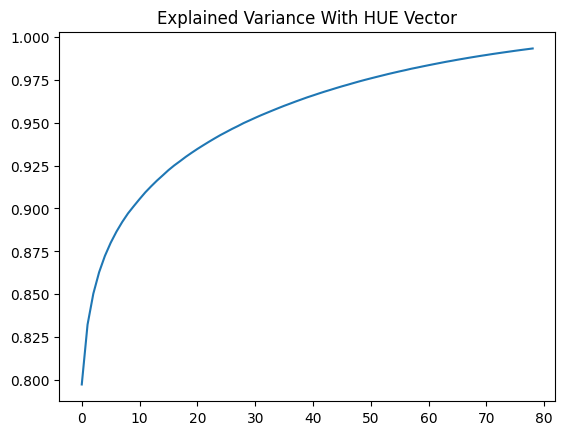

In [64]:
explained_variance = []

for components in range(5,400, 5):
    pca = PCA(n_components=components)
    pca.fit(v)
    sum = np.sum(pca.explained_variance_ratio_)
    explained_variance.append(sum)

plt.plot(explained_variance)
plt.title("Explained Variance With HUE Vector")

In [49]:
explained_variance[-1]

0.780544658204337

## Testing Set Distribution

In [9]:

display(testing_set.groupby("category").agg(Count=('category', 'count')))


Count
category        
buildings    437
forest       474
glacier      553
mountain     525
sea          510
street       501

## Training Set Distribution

In [10]:

# Find images that are not full resoultion
training_set['full_resolution'] = training_set['resolution'] == (150,150)

full_res_pics= training_set[training_set['full_resolution']].groupby("category") \
                                                            .count()[['full_resolution']] \
                                                            .rename(columns={'full_resolution': 'Full Resolution'})

full_res_pics['Partial Resolution'] = training_set[training_set['full_resolution']==False].groupby("category") \
                                                                                          .count()['full_resolution']
full_res_pics.loc['Total']   = full_res_pics.sum(numeric_only=True, axis=0)
full_res_pics.loc[:,'Total'] = full_res_pics.sum(numeric_only=True, axis=1)
display(full_res_pics)


Full Resolution  Partial Resolution  Total
category                                             
buildings             2190                   1   2191
forest                2263                   8   2271
glacier               2387                  17   2404
mountain              2495                  17   2512
sea                   2270                   4   2274
street                2381                   1   2382
Total                13986                  48  14034

In [11]:
## Monochromatic Images

In [12]:

# Monochromatic Images
display(training_set[training_set['stddev_h'] == 0 ].groupby("category")
                                                    .agg(Count=('category', 'count'))
                                                    .rename(columns={'Count':'Monochromatic Images'}))


Monochromatic Images
category                       
buildings                    94
forest                       68
glacier                      20
mountain                     22
sea                          82
street                      330

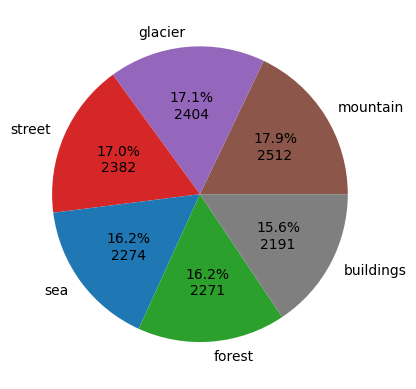

In [17]:

# Plot A Few Interesting Stats
colors = {'buildings':'tab:gray', 
         'forest'    :'tab:green', 
         'glacier'   :'tab:purple', 
         'mountain'  :'tab:brown', 
         'sea'       :'tab:blue', 
         'street'    :'tab:red'}

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, training_set.shape[0]*x/100)

plt.pie(training_set['category'].value_counts().values, 
        labels=training_set['category'].value_counts().index, 
        autopct=fmt, 
        colors=[colors[v] for v in training_set['category'].value_counts().keys()])
plt.show()


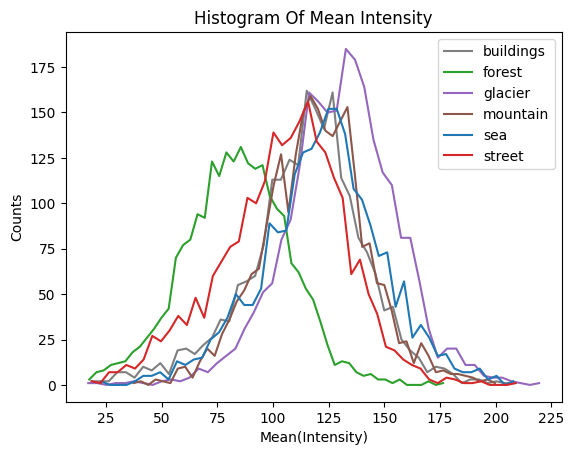

In [18]:

# Throw up some Intensity Histograms
groups = training_set.groupby('category')

fig, ax = plt.subplots()
for name, group in groups:
    counts, bins = np.histogram(group['mean_l'], 50)
    ax.plot(bins[:-1], counts,label=name, color=colors[name])
ax.legend()
plt.title("Histogram Of Mean Intensity")
plt.xlabel("Mean(Intensity)")
plt.ylabel("Counts")
plt.show()
fig.savefig("histograms.png")


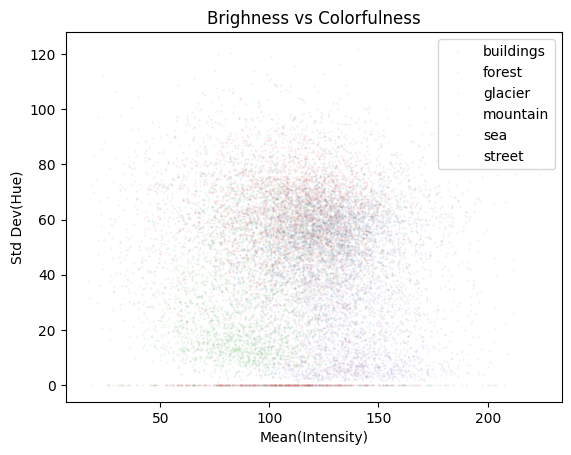

In [23]:

# Do a scatter plot of colorfulness vs intesity

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.mean_l, group.stddev_h, marker='.', linestyle='', ms=1, label=name, color=colors[name],alpha=0.1)
ax.legend()
plt.title("Brighness vs Colorfulness")
plt.xlabel("Mean(Intensity)")
plt.ylabel("Std Dev(Hue)")
plt.show()
fig.savefig('scatter_plot.png')


## Sample Image

The following image shows a sample of a few images of each category.

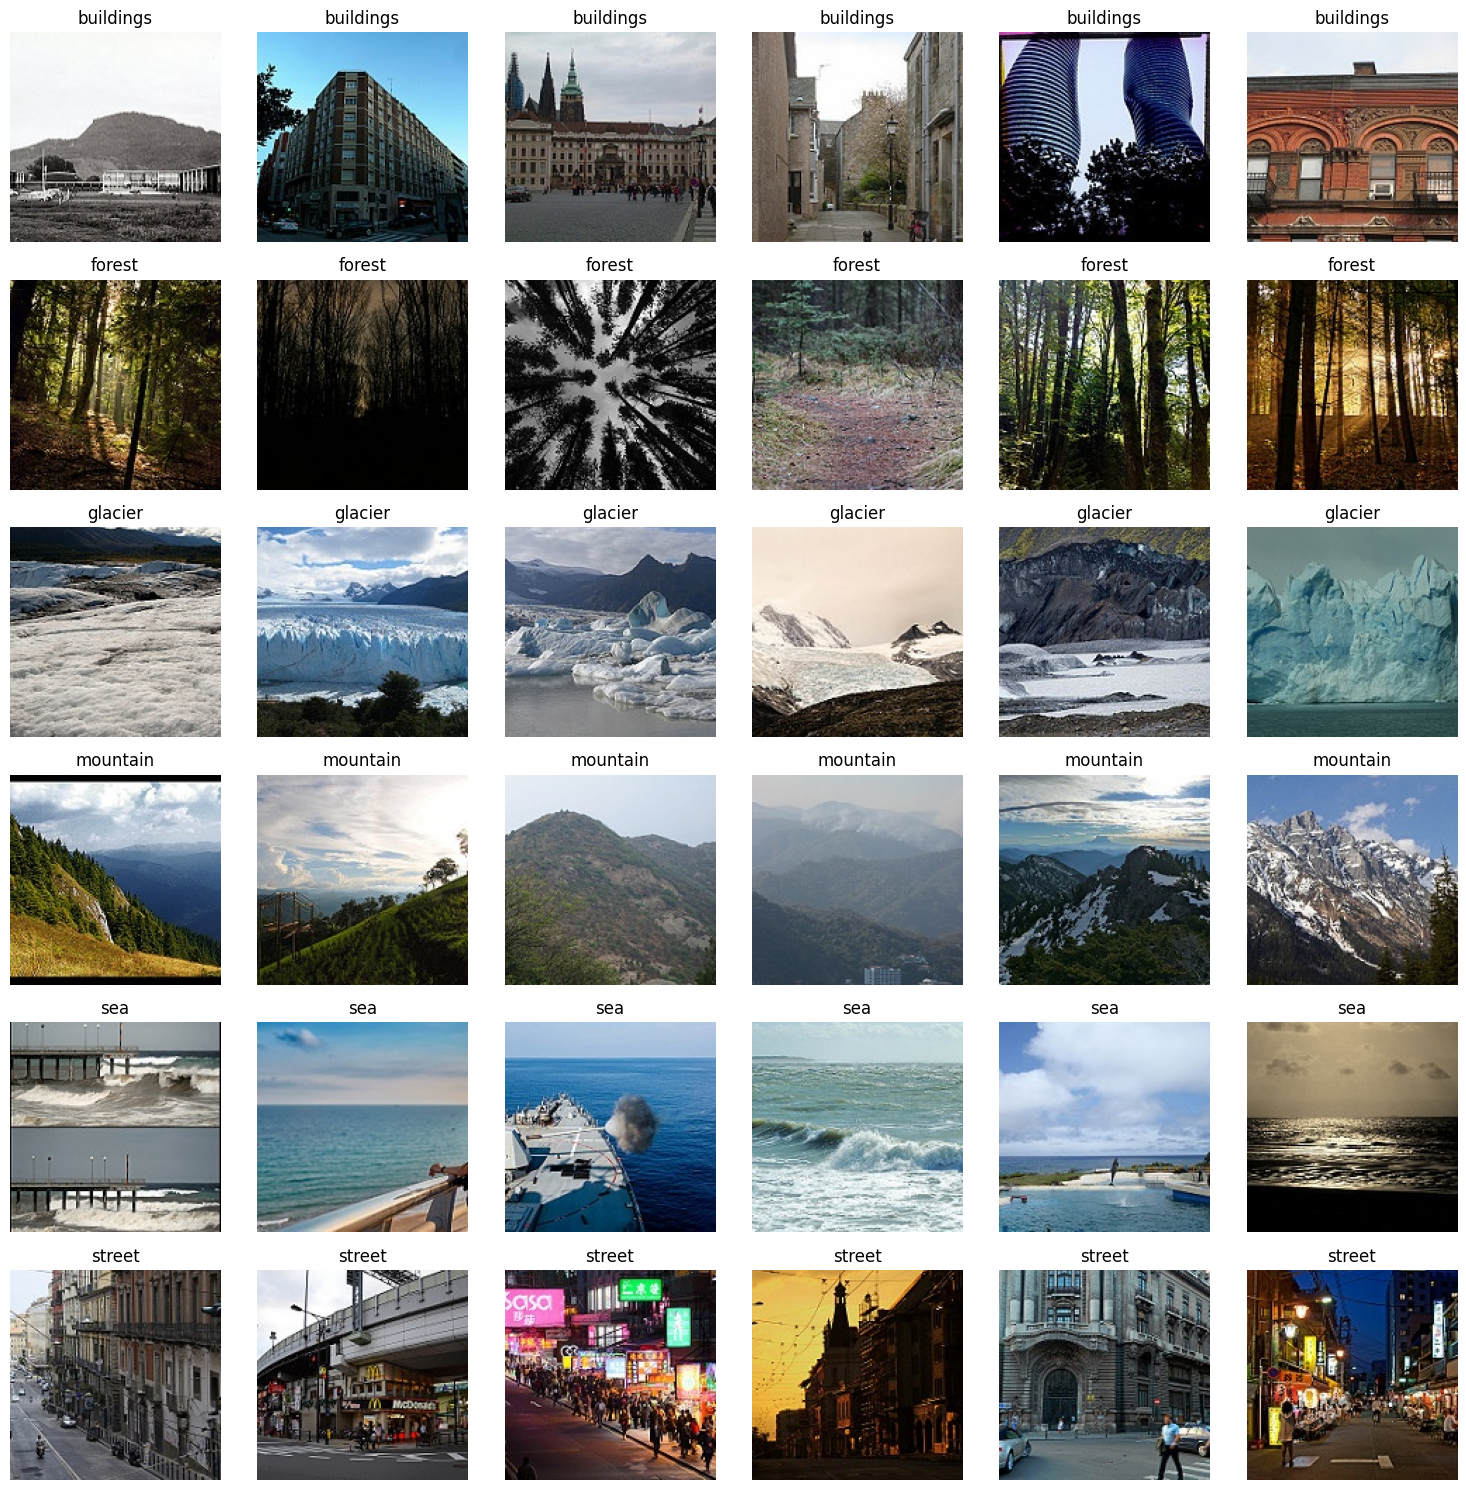

In [16]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))

for idx,row in training_set.groupby("category").head(6).reset_index().iterrows():
    
    category = row['category']
    img = Image.open(row['filename'])
    ax[idx // 6 ][idx % 6 ].imshow(img)
    ax[idx // 6 ][idx % 6 ].axis('off')
    ax[idx // 6 ][idx % 6 ].set_title(category)
  
plt.tight_layout()
plt.show()
fig.savefig('example_img.png')

## Image features:
1. Histogram of Oriented
Gradients (HOG): HOG captures the distribution of directions of oriented gradients in localized portions of an image. It is useful for object detection in our image (i.e. buildings has very vertical oriented edges).
2. Color Histograms: Evaluating colors using methods like RGB or HSV histograms is valuable due to the distinct color variations in natural images (i.e.  mountains vs. seas vs. and glaciers).
3. Edge Detection: Techniques like Canny Edge Detection highlight important boundaries within images, aiding in object recognition.
